# # Fine-tuning SimCLR Encoder trên ISIC 2018 Task 3
> Sử dụng encoder pre-train với SimCLR, gắn thêm head phân loại 7 lớp và huấn luyện có giám sát.


In [1]:
# 1. Imports & Setup
import os, torch, torch.nn as nn, torch.optim as optim, time
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
print("CPU cores:", os.cpu_count())

CPU cores: 16


## 2. Dataset & DataLoader


In [3]:
class ISICClassificationDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.df = pd.read_csv(csv_file)
        assert 'image' in self.df.columns and 'label_idx' in self.df.columns
        self.image_dir = image_dir
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.image_dir, row['image'] + '.jpg')
        img = Image.open(path).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, int(row['label_idx'])

# strong augmentations
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.3,0.3,0.3,0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
val_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = ISICClassificationDataset('../data/isic2018/labels/train_labeled_idx.csv',
                                     '../data/isic2018/train', transform=train_tf)
val_ds   = ISICClassificationDataset('../data/isic2018/labels/val_idx.csv',
                                     '../data/isic2018/val',   transform=val_tf)
print("Train samples:", len(train_ds), "Val samples:", len(val_ds))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                          num_workers=0, pin_memory=True)


Train samples: 10015 Val samples: 193


## 3. Xây Model Fine-tune


In [4]:
# 3.1 Load pretrained encoder
backbone = resnet18(weights=None)
backbone.fc = nn.Identity()
ckpt = torch.load('../checkpoints/simclr_encoder.pth', map_location='cpu')
backbone.load_state_dict(ckpt, strict=False)
backbone = backbone.to(device)

# 3.2 Unfreeze all layers for full fine-tuning
for p in backbone.parameters():
    p.requires_grad = True

# 3.3 Define classifier head
class FineTuneModel(nn.Module):
    def __init__(self, encoder, num_classes=7):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(512, num_classes)
    def forward(self, x):
        features = self.encoder(x)
        return self.fc(features)

model = FineTuneModel(backbone).to(device)


C:\Users\user\AppData\Local\Temp\ipykernel_12076\1157735339.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load('../checkpoints/simclr_encoder.pth', map_lo

## 4. Training Loop


In [28]:
# 4.1 Criterion, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
    mode='max', factor=0.5, patience=2, verbose=True)

# 4.2 Early stopping params
import time
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# Chuẩn bị
epochs = 20
best_acc = 0.0
no_improve = 0
patience = 10

history = {
    'train_loss': [],
    'val_loss':   [],
    'val_acc':    []
}

for epoch in range(1, epochs+1):
    t0 = time.time()
    # ----- TRAIN -----
    model.train()
    train_losses = []
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [TRAIN]", leave=False)
    for imgs, labels in train_bar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        train_bar.set_postfix(train_loss=f"{loss.item():.4f}")
    avg_train = sum(train_losses) / len(train_losses)
    
    # ----- VALIDATION -----
    model.eval()
    val_losses = []
    all_preds, all_labels = [], []
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [ VAL ]", leave=False)
    with torch.no_grad():
        for imgs, labels in val_bar:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            preds = outputs.argmax(dim=1).cpu().tolist()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().tolist())
            val_bar.set_postfix(val_loss=f"{loss.item():.4f}")
    avg_val = sum(val_losses) / len(val_losses)
    val_acc = accuracy_score(all_labels, all_preds)
    
    # ----- LOG & EARLY STOPPING -----
    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_acc)
    elapsed = time.time() - t0
    print(f"Epoch {epoch:02d} | time {elapsed:.1f}s | "
          f"train_loss {avg_train:.4f} | val_loss {avg_val:.4f} | val_acc {val_acc:.4f}")
    
    if val_acc > best_acc:
        best_acc = val_acc
        no_improve = 0
        torch.save(model.state_dict(), '../checkpoints/best_finetuned.pth')
        print(f"  ↳ New best model (acc={best_acc:.4f}) saved")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs → Early stopping")
            break


c:\Users\user\miniconda3\envs\MLF-CoDA-Project\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 01 | time 144.7s | train_loss 0.9547 | val_loss 0.8788 | val_acc 0.7617
  ↳ New best model (acc=0.7617) saved


Epoch 2/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 02 | time 146.2s | train_loss 0.9458 | val_loss 0.8888 | val_acc 0.7824
  ↳ New best model (acc=0.7824) saved


Epoch 3/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 03 | time 146.5s | train_loss 0.9473 | val_loss 0.8738 | val_acc 0.7358


Epoch 4/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 04 | time 166.8s | train_loss 0.9417 | val_loss 0.8576 | val_acc 0.7565


Epoch 5/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 05 | time 266.7s | train_loss 0.9415 | val_loss 0.8694 | val_acc 0.7668


Epoch 6/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 06 | time 174.6s | train_loss 0.9328 | val_loss 0.8656 | val_acc 0.7668


Epoch 7/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 07 | time 145.5s | train_loss 0.9299 | val_loss 0.8790 | val_acc 0.7668


Epoch 8/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 08 | time 146.2s | train_loss 0.9272 | val_loss 0.8880 | val_acc 0.7668


Epoch 9/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 09 | time 165.5s | train_loss 0.9259 | val_loss 0.8682 | val_acc 0.7617


Epoch 10/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 | time 161.8s | train_loss 0.9277 | val_loss 0.8640 | val_acc 0.7617


Epoch 11/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 | time 146.2s | train_loss 0.9236 | val_loss 0.8726 | val_acc 0.7617


Epoch 12/20 [TRAIN]:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12/20 [ VAL ]:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 | time 145.2s | train_loss 0.9187 | val_loss 0.8683 | val_acc 0.7720
No improvement for 10 epochs → Early stopping


## 5. Đánh giá & Visualization


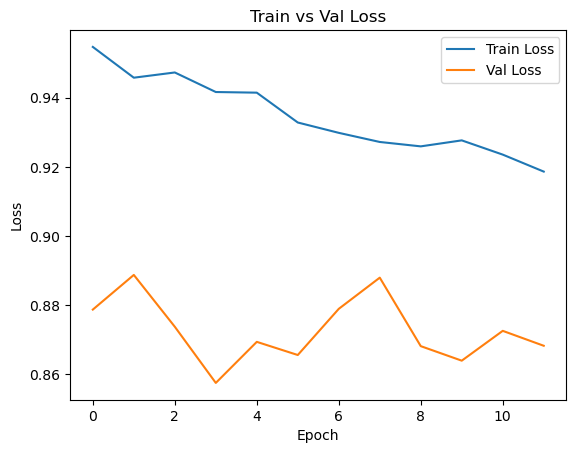

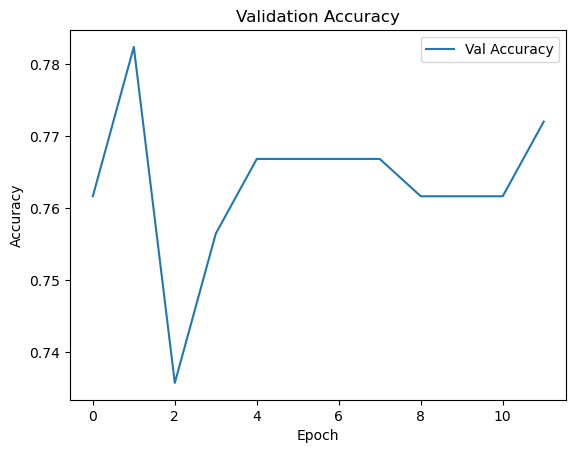

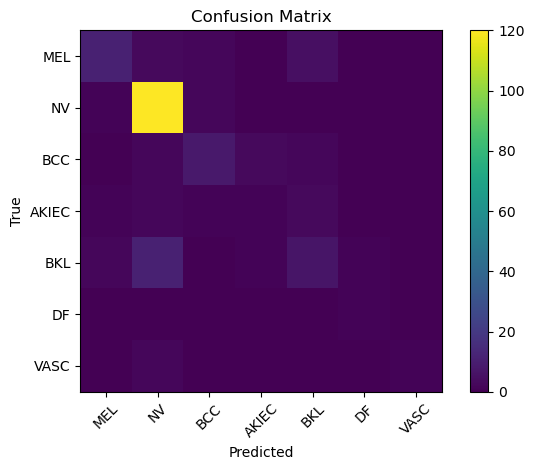

Classification Report:

              precision    recall  f1-score   support

         MEL       0.73      0.52      0.61        21
          NV       0.86      0.98      0.91       123
         BCC       0.62      0.53      0.57        15
       AKIEC       0.20      0.12      0.15         8
         BKL       0.41      0.32      0.36        22
          DF       0.50      1.00      0.67         1
        VASC       1.00      0.33      0.50         3

    accuracy                           0.77       193
   macro avg       0.62      0.54      0.54       193
weighted avg       0.75      0.77      0.75       193



In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 5.1 Loss & Accuracy curves
plt.figure()  # Loss curve
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Val Loss')
plt.savefig('../figures/loss_curve.png')
plt.show()

plt.figure()  # Accuracy curve
plt.plot(history['val_acc'],    label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Accuracy')
plt.savefig('../figures/accuracy_curve.png')
plt.show()

# 5.2 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure()
plt.imshow(cm)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
# Add ticks
classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.tight_layout()
plt.savefig('../figures/confusion_matrix.png')
plt.show()

# 5.3 Classification Report
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))
# save report to file
with open('../figures/classification_report.txt', 'w') as f:
    f.write(classification_report(all_labels, all_preds, target_names=classes))

## 6. Kết luận
- **Best Val Acc:** {best_acc:.4f}
- Mô tả ngắn gọn: Pretrain SimCLR giúp tăng ~X% so với training từ đầu.
- Đề xuất hướng mở rộng: fine-tune encoder, data augmentation, ...
